In [1]:
import torch
print(torch.cuda.is_available())  # Should return True if the GPU is available
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

True
NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import random
import pytorch_lightning as pl
import time

from darts import TimeSeries
from darts.models import RNNModel, TFTModel
from darts.metrics import mape, rmse, mae, mse
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler as DartsScaler

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Input, Dropout, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
# Set random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)

# loading data

In [4]:
# 1. Load data
url = 'https://raw.githubusercontent.com/zhuppyra/Price-Forecasting-Data-Only-/refs/heads/main/Harga%20PIHPS%20v.2.csv'
df = pd.read_csv(url)
# start from 1st day of a month
#df = df.iloc[5:-5]
df['Date'] = pd.to_datetime(df['Date'])
# Reset the index of the sliced DataFrame
#data = data.reset_index(drop=True)
# Step 2: Set the 'date' column as the index
df.set_index('Date', inplace=True)
df

,Rice,Chicken_meat,Beef,Chicken_egg,Shallot,Garlic,Red_chili,Bird's_eye_chili,Cooking_oil,Sugar
Date,,,,,,,,,,
2017-08-01,11200.000000,34100.000000,115150.0,22850.000000,33200.0,33350.0,32000.000000,41050.000000,13950.0,14900.0
2017-08-02,11200.000000,34150.000000,115150.0,22800.000000,32950.0,33150.0,32200.000000,40600.000000,13950.0,14900.0
2017-08-03,11200.000000,34250.000000,115250.0,22800.000000,32650.0,33150.0,32400.000000,40350.000000,13950.0,14900.0
2017-08-04,11300.000000,34300.000000,115000.0,22750.000000,32150.0,33000.0,32250.000000,40500.000000,13950.0,14900.0
2017-08-05,11266.666667,34316.666667,115100.0,22733.333333,31850.0,32800.0,32266.666667,40166.666667,13950.0,14900.0
...,...,...,...,...,...,...,...,...,...,...
2024-08-27,15350.000000,35650.000000,135450.0,29550.000000,28250.0,42200.0,46700.000000,55750.000000,19300.0,18450.0
2024-08-28,15250.000000,35150.000000,134950.0,29350.000000,28100.0,42150.0,46150.000000,55050.000000,19300.0,18450.0
2024-08-29,15300.000000,35300.000000,135650.0,29400.000000,27750.0,42050.0,45200.000000,53100.000000,19250.0,18400.0


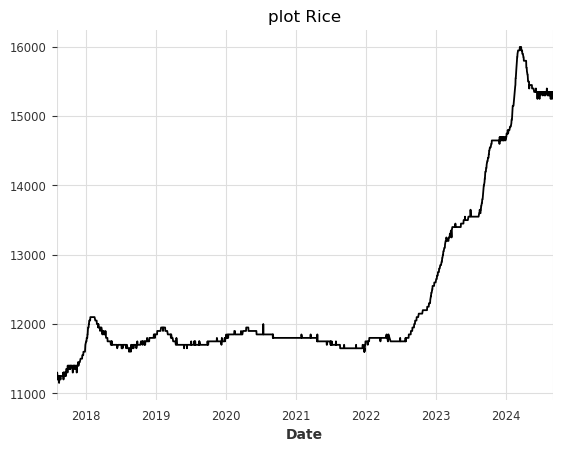

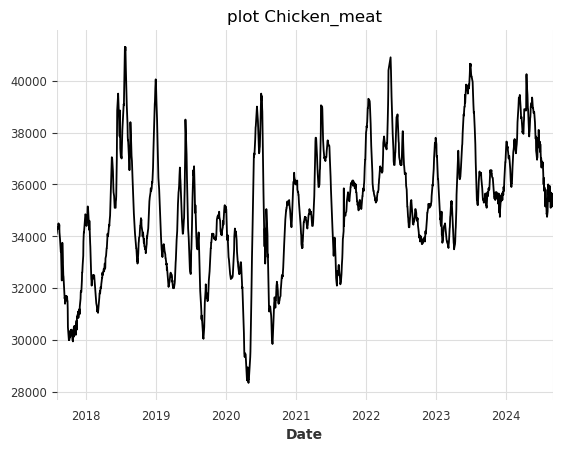

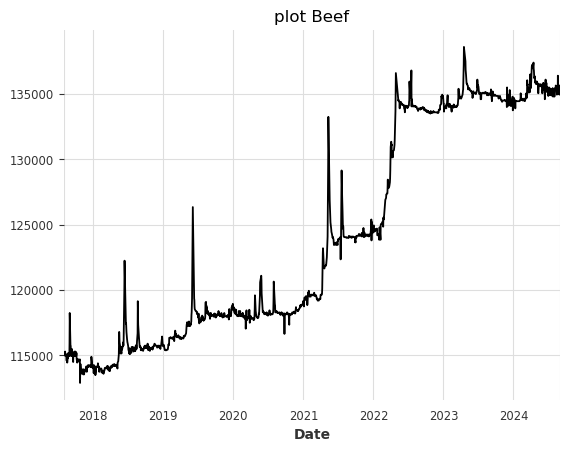

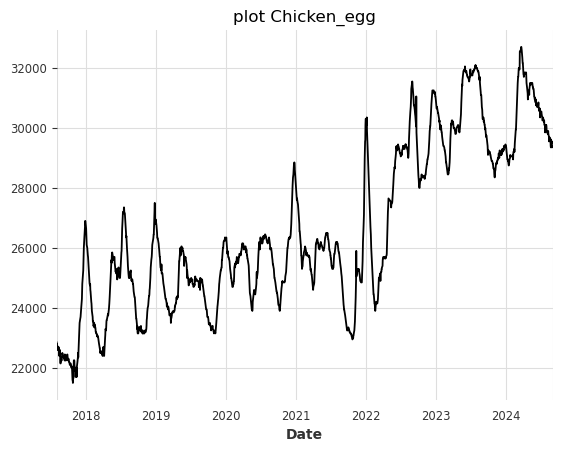

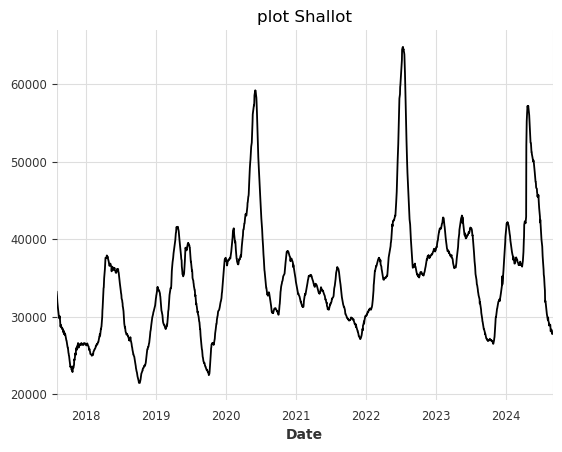

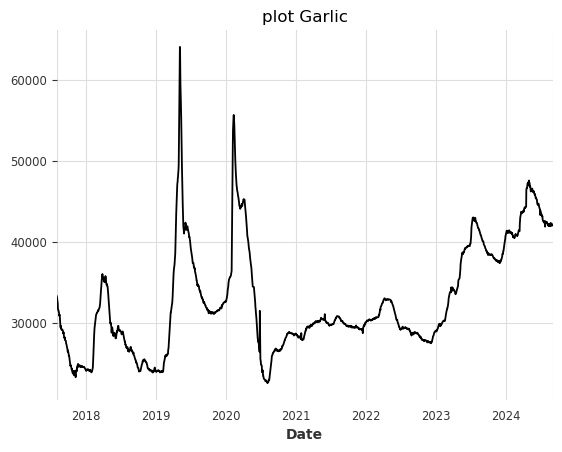

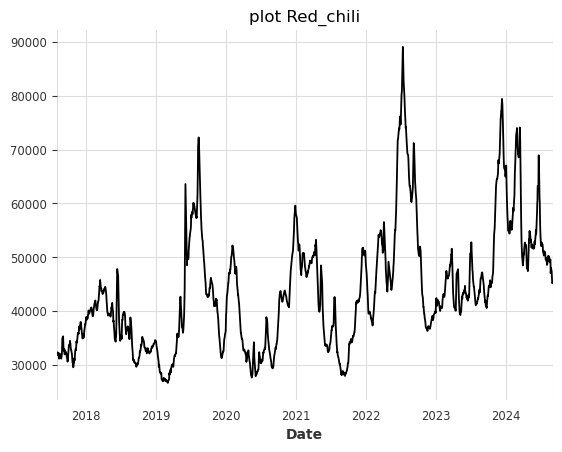

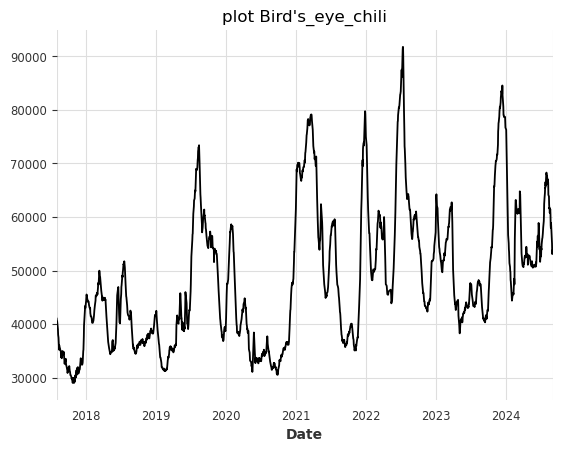

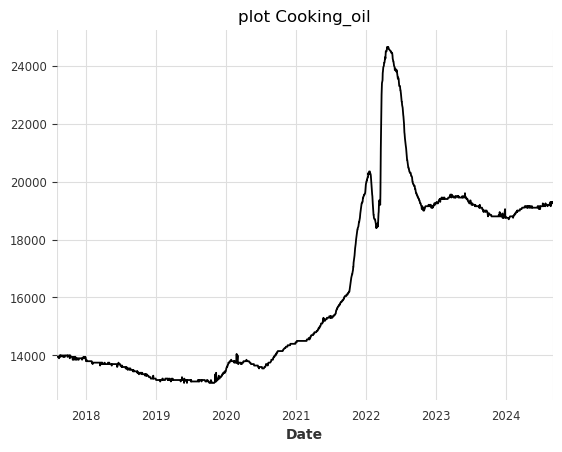

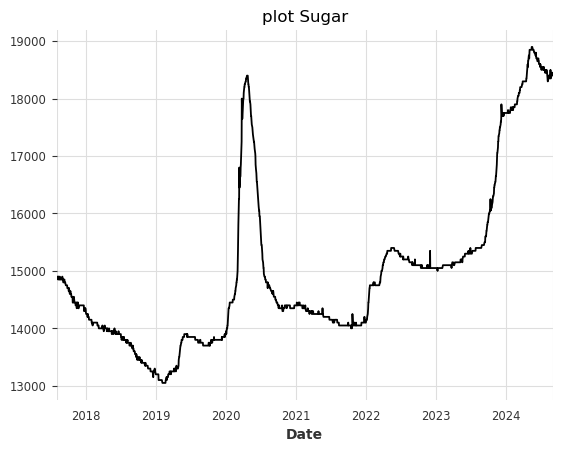

In [5]:
for col in df.columns:
    df[col].plot(title=f'plot {col}')
    plt.show()

In [7]:
commodity = "Bird's_eye_chili"
data = df[[commodity]]
data.head()

,Bird's_eye_chili
Date,
2017-08-01,41050.000000
2017-08-02,40600.000000
2017-08-03,40350.000000
2017-08-04,40500.000000
2017-08-05,40166.666667


In [9]:
# Define the splitting points
train_end = pd.Timestamp('2023-04-30')
val_start = train_end + pd.Timedelta(days=1)  # 2023-05-02
val_end = pd.Timestamp('2023-12-31')
test_start = val_end + pd.Timedelta(days=1)   # 2024-01-02

# Split the data
train = data.loc[:train_end]
val = data.loc[val_start:val_end]
test = data.loc[test_start:]

# Check the size of each set
print(f"Train set: {len(train)} rows")
print(f"Validation set: {len(val)} rows")
print(f"Test set: {len(test)} rows")

# Convert to numpy arrays
train_array = train.values
val_array = val.values
test_array = test.values

Train set: 2099 rows
Validation set: 245 rows
Test set: 244 rows


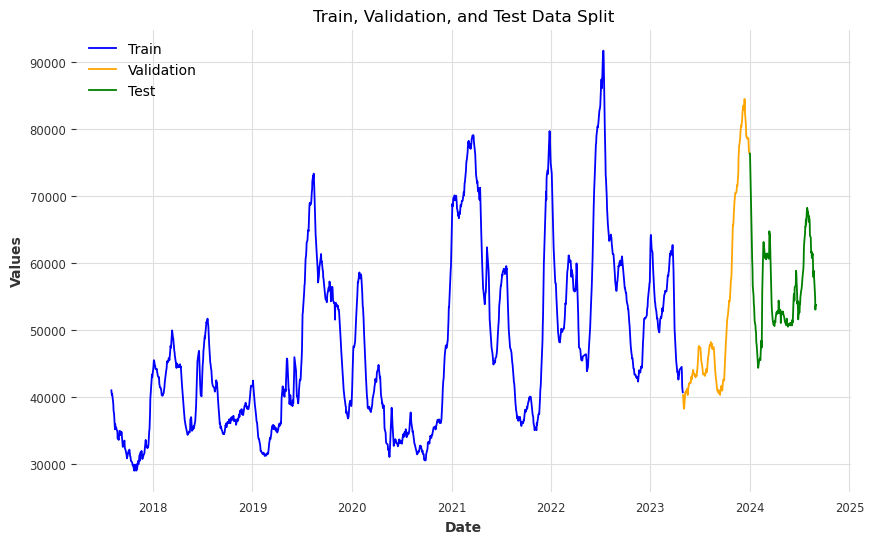

In [10]:
import matplotlib.pyplot as plt

# Plot the data with different colors for each split
plt.figure(figsize=(10, 6))

# Plot the train data in blue
plt.plot(train.index, train.values, label='Train', color='blue')

# Plot the validation data in orange
plt.plot(val.index, val.values, label='Validation', color='orange')

# Plot the test data in green
plt.plot(test.index, test.values, label='Test', color='green')

# Add labels and a title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Train, Validation, and Test Data Split')

# Add a legend to distinguish between the splits
plt.legend()

# Show the plot
plt.show()


# LSTM & GRU

In [23]:
# Define the splitting points
train_end_keras = pd.Timestamp('2023-04-30')
val_start_keras = train_end + pd.Timedelta(days=1)  # 2023-05-02
val_end_keras = pd.Timestamp('2023-12-02')
test_start_keras = val_end + pd.Timedelta(days=1)   # 2024-01-02

# Split the data
train_keras = data.loc[:train_end_keras]
val_keras = data.loc[val_start_keras:val_end_keras]
test_keras = data.loc[test_start_keras:]

# Print the start and end time, along with the number of data points
print(f"Train set: {train_keras.index[0]} to {train_keras.index[-1]} ({len(train_keras)} points)")
print(f"Validation set: {val_keras.index[0]} to {val_keras.index[-1]} ({len(val_keras)} points)")
print(f"Test set: {test_keras.index[0]} to {test_keras.index[-1]} ({len(test_keras)} points)")

# Convert to numpy arrays
train_array_keras = train_keras.values
val_array_keras = val_keras.values
test_array_keras = test_keras.values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled_keras = scaler.fit_transform(train_array_keras.reshape(-1, 1))
val_scaled_keras = scaler.transform(val_array_keras.reshape(-1, 1))
test_scaled_keras = scaler.transform(test_array_keras.reshape(-1, 1))

# Parameters
N_STEPS_IN = 30
N_STEPS_OUT = 30
n_features = 1
batch_size = 16
epochs = 50

# Prepare data for Keras models
def create_dataset(dataset, N_STEPS_IN, N_STEPS_OUT):
    X, y = [], []
    for i in range(len(dataset) - N_STEPS_IN - N_STEPS_OUT + 1):
        X.append(dataset[i:(i + N_STEPS_IN), 0])
        y.append(dataset[(i + N_STEPS_IN):(i + N_STEPS_IN + N_STEPS_OUT), 0])
    return np.array(X), np.array(y)

X_train_keras, y_train_keras = create_dataset(train_scaled_keras, N_STEPS_IN, N_STEPS_OUT)
X_val_keras, y_val_keras = create_dataset(val_scaled_keras, N_STEPS_IN, N_STEPS_OUT)

# Reshape input for Keras models [samples, timesteps, features]
X_train_keras = X_train_keras.reshape((X_train_keras.shape[0], X_train_keras.shape[1], n_features))
X_val_keras = X_val_keras.reshape((X_val_keras.shape[0], X_val_keras.shape[1], n_features))

Train set: 2017-08-01 00:00:00 to 2023-04-30 00:00:00 (2099 points)
Validation set: 2023-05-01 00:00:00 to 2023-12-02 00:00:00 (216 points)
Test set: 2024-01-01 00:00:00 to 2024-08-31 00:00:00 (244 points)


In [24]:
#tf.random.set_seed(seed)

# Create Keras GRU model
def create_gru_model():
    model = Sequential([
        Input(shape=(N_STEPS_IN, n_features)),
        GRU(96, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(N_STEPS_OUT)
    ])
    model.compile(optimizer=Adam(learning_rate=0.000572098), loss='mse')
    return model

# Create Keras LSTM model
def create_lstm_model():
    model = Sequential([
        Input(shape=(N_STEPS_IN, n_features)),
        LSTM(128, activation='tanh', return_sequences=False),
        Dropout(0.15),
        Dense(N_STEPS_OUT)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001303128), loss='mse')
    return model

In [25]:
# Training GRU model
gru_start_time = time.time()
gru_model = create_gru_model()
gru_history = gru_model.fit(X_train_keras,
                            y_train_keras,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_val_keras, y_val_keras),
                            verbose=1)
gru_end_time = time.time()

# Training LSTM model
lstm_start_time = time.time()
lstm_model = create_lstm_model()
lstm_history = lstm_model.fit(X_train_keras,
                              y_train_keras,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=(X_val_keras, y_val_keras),
                              verbose=1)

lstm_end_time = time.time()

# Calculate the elapsed time
lstm_elapsed_time = lstm_end_time - lstm_start_time
gru_elapsed_time = gru_end_time - gru_start_time
print(f"LSTM Execution time: {lstm_elapsed_time} seconds")
print(f"GRU Execution time: {gru_elapsed_time} seconds")

Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0607 - val_loss: 0.0151
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0153 - val_loss: 0.0109
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0138 - val_loss: 0.0125
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0124 - val_loss: 0.0100
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0121 - val_loss: 0.0092
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0116 - val_loss: 0.0102
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0113 - val_loss: 0.0092
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0105 - val_loss: 0.0095
Epoch 9/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 10/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 11/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0107 - val_loss: 0.0086
Epoch 12/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/st

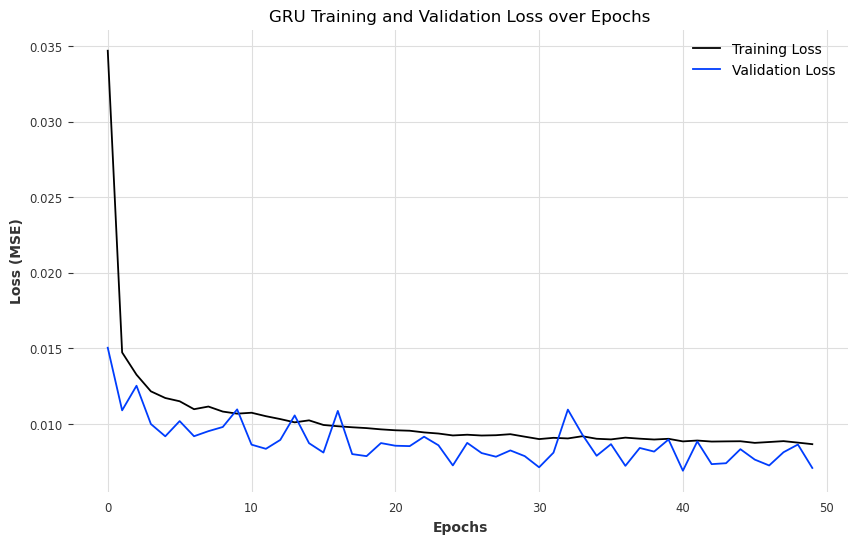

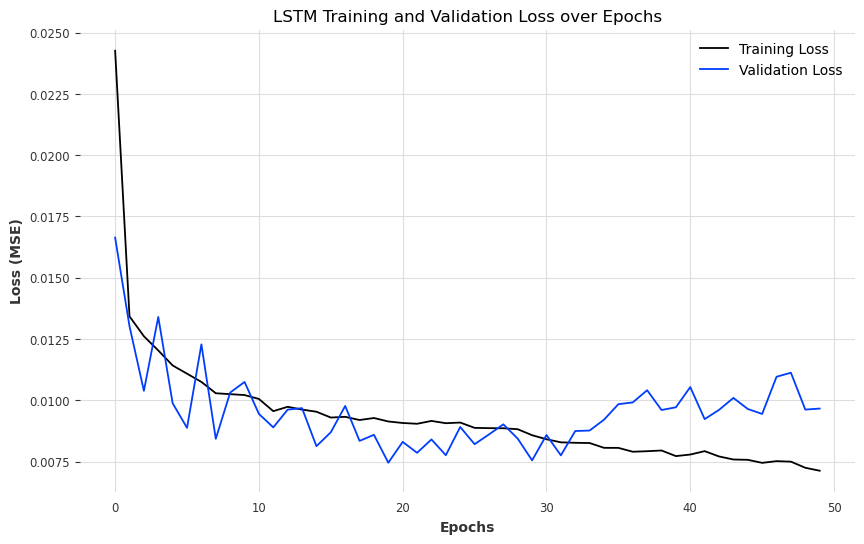

In [26]:
import matplotlib.pyplot as plt

# Extract loss and validation loss
train_loss = gru_history.history['loss']
val_loss = gru_history.history['val_loss']

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('GRU Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Extract loss and validation loss
train_loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('LSTM Training and Validation Loss over Epochs')
plt.legend()
plt.show()


# GridSearch for patience

In [52]:
from sklearn.model_selection import GridSearchCV

# Define patience values to search over
patience_values = [3, 5, 7, 10, 15, 20, 25]

# Loop over patience values
best_patience = None
best_val_loss = float('inf')

for patience in patience_values:
    # Train the model with different patience values
    print(f"Training GRU with patience={patience}")

    # Create and compile the model
    gru_model = create_gru_model()
    
    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=patience,
            restore_best_weights=True,
            verbose=1
        )
    ]
    
    # Train the model
    gru_history = gru_model.fit(
        X_train_keras, y_train_keras,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_keras, y_val_keras),
        callbacks=callbacks,
        verbose=1
    )

    # Get the best validation loss
    val_loss = min(gru_history.history['val_loss'])
    
    print(f"Patience {patience}: Best validation loss = {val_loss}")
    
    # Update the best patience if this is the best so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_patience = patience

print(f"GRU best patience: {best_patience} with validation loss: {best_val_loss}")

# Loop over patience values
lstm_best_patience = None
best_val_loss = float('inf')

for patience in patience_values:
    # Train the model with different patience values
    print(f"Training LSTM with patience={patience}")
    
    # Build model
    lstm_model = create_lstm_model()

     # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=patience,
            restore_best_weights=True,
            verbose=1
        )
    ]
    
    # Train the model
    lstm_history = lstm_model.fit(
        X_train_keras, y_train_keras,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_keras, y_val_keras),
        callbacks=callbacks,
        verbose=1
    )
                                
    # Get the validation loss at the end of training
    val_loss = min(lstm_history.history['val_loss'])

    # Save the best patience and validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        lstm_best_patience = patience

print(f"LSTM best patience: {lstm_best_patience} with validation loss: {best_val_loss}")

Training GRU with patience=3
Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0268 - val_loss: 0.0031
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0072 - val_loss: 0.0012
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0055 - val_loss: 0.0023
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0059 - val_loss: 0.0021
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0055 - val_loss: 0.0016
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
Patience 3: Best validation loss = 0.001206046319566667
Training GRU with patience=5
Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0225 - val_loss: 0.0052
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0070 - val_loss: 0.0011
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0055 - val_loss: 0.0012
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0062 - val_loss: 0.0010
Epoch 5/50
128/128 ━

In [53]:
# Define callbacks
gru_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=best_patience,
        restore_best_weights=True,
        verbose=1
    )
]

lstm_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=lstm_best_patience,
        restore_best_weights=True,
        verbose=1
    )
]

print(f'Using LSTM best patience ({lstm_best_patience}) and GRU best patience ({best_patience})')

lstm_start_time = time.time()

# Train Keras models
lstm_model = create_lstm_model()
lstm_history = lstm_model.fit(X_train_keras,
                              y_train_keras,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=(X_val_keras, y_val_keras),
                              callbacks=lstm_callbacks,
                              verbose=1)

lstm_end_time = time.time()

gru_start_time = time.time()
gru_model = create_gru_model()
gru_history = gru_model.fit(X_train_keras,
                            y_train_keras,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_val_keras, y_val_keras),
                            callbacks=gru_callbacks,
                            verbose=1)
gru_end_time = time.time()

# Calculate the elapsed time
lstm_elapsed_time = lstm_end_time - lstm_start_time
gru_elapsed_time = gru_end_time - gru_start_time
print(f"LSTM Execution time: {lstm_elapsed_time} seconds")
print(f"GRU Execution time: {gru_elapsed_time} seconds")

Using LSTM best patience (10) and GRU best patience (7)
Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0188 - val_loss: 0.0021
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0056 - val_loss: 0.0013
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0049 - val_loss: 0.0035
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 9/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 10/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 11/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0027 - va

# Darts TFT

In [17]:
# Prepare data for TFT model
darts_scaler = DartsScaler()
series = TimeSeries.from_series(data)
train_series = TimeSeries.from_series(train)
val_series = TimeSeries.from_series(val)
test_series = TimeSeries.from_series(test)

train_scaled_darts = darts_scaler.fit_transform(train_series)
val_scaled_darts = darts_scaler.transform(val_series)
test_scaled_darts = darts_scaler.transform(test_series)

print(f"Train set: {train_scaled_darts.start_time()} to {train_scaled_darts.end_time()} ({len(train)} points)")
print(f"Validation set: {val_scaled_darts.start_time()} to {val_scaled_darts.end_time()} ({len(val)} points)")
print(f"Test set: {test_scaled_darts.start_time()} to {test_scaled_darts.end_time()} ({len(test)} points)")

Train set: 2017-08-01 00:00:00 to 2023-04-30 00:00:00 (2099 points)
Validation set: 2023-05-01 00:00:00 to 2023-12-31 00:00:00 (245 points)
Test set: 2024-01-01 00:00:00 to 2024-08-31 00:00:00 (244 points)


In [18]:
in_len_delta = pd.Timedelta(days=N_STEPS_IN)  # Example: 30 days of past context for the model

# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = DartsScaler()
# Similarly split the covariates
train_covariates = covariates[:train_end]
val_covariates = covariates[train_end:val_end]
test_covariates = covariates[val_end:]
model_val_covariates = covariates[train_end - in_len_delta:val_end]
extended_covariates = covariates[:val_end]

# scale covariates
scaler_covs.fit(train_covariates)
covariates_transformed = scaler_covs.transform(covariates)
#train_covariates_scaled = scaler_covs.transform(train_covariates)
val_covariates_scaled = scaler_covs.transform(val_covariates)
model_val_covariates_scaled = scaler_covs.transform(model_val_covariates)
test_covariates_scaled = scaler_covs.transform(test_covariates)
extended_covariates_scaled = scaler_covs.transform(extended_covariates)

In [36]:
def build_fit_tft_model(
    in_len,
    out_len,
    hidden_size,
    num_attention_heads,
    dropout,
    lr,
    callbacks=None
):

    
    # reproducibility
    #torch.manual_seed(42)

    # some fixed parameters that will be the same for all models
    BATCH_SIZE = 16
    MAX_N_EPOCHS = 50
    N_LSTM_LAYERS = 1

    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = pl.callbacks.EarlyStopping("val_loss", min_delta=0.0005, patience=5, verbose=True)
    all_callbacks = [early_stopper] + (callbacks or [])
    
    pl_trainer_kwargs = {
        "callbacks": all_callbacks,
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
    }

    # Create and train TFT model
    tft_model = TFTModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=hidden_size,
        lstm_layers=N_LSTM_LAYERS,
        num_attention_heads=num_attention_heads,
        dropout=dropout,
        batch_size=BATCH_SIZE,
        n_epochs=MAX_N_EPOCHS,
        optimizer_kwargs={"lr": lr},
        pl_trainer_kwargs=pl_trainer_kwargs,
        likelihood=None,         
        add_relative_index=False,
        #add_encoders=None,
        loss_fn=torch.nn.MSELoss(),
        #model_name="tft_model",
        #force_reset=True,
        #save_checkpoints=True,
        #random_state=42
    )

    # Assume in_len is defined as the number of days or hours as a timedelta
    in_len_delta = pd.Timedelta(days=N_STEPS_IN)  # Example: 30 days of past context for the model

    # Create the extended validation set (model_val_set) by adding in_len before the validation period
    model_val_set = data.loc[train_end - in_len_delta:val_end]
    model_val_series = TimeSeries.from_series(model_val_set)
    # You can apply transformations like scaling to model_val_set if needed, as you did with the validation set
    # For example, assuming scaler is already defined:
    model_val_set_scaled = darts_scaler.transform(model_val_series)

    # Fitting the model with both target and covariates
    tft_model.fit(
        series=train_scaled_darts,
        future_covariates=covariates_transformed,
        val_series=model_val_set_scaled,
        val_future_covariates=model_val_covariates_scaled,
        dataloader_kwargs={"num_workers": 4,"persistent_workers":True},
        verbose=True
    )

    # reload best model over course of training
    #tft_model = TFTModel.load_from_checkpoint("tft_model")

    return tft_model

In [37]:
hidden_size=112
num_attention_heads=2
dropout=0.1952109542043864
lr=0.003909304343315927

In [38]:
tft_start_time = time.time()

tft_model = build_fit_tft_model(
    in_len=N_STEPS_IN,
    out_len=N_STEPS_OUT,
    hidden_size=hidden_size,
    num_attention_heads=num_attention_heads,
    dropout=dropout,
    lr=lr
)

tft_end_time = time.time()

# Calculate the elapsed time
tft_elapsed_time = tft_end_time - tft_start_time
print(f"TFT Execution time: {tft_elapsed_time} seconds")
print(tft_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0      | train
1  | train_criterion                   | MSELoss                          | 0      | train
2  | val_criterion                     | MSELoss                          | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | val_metrics                       | MetricCollection                 | 0      | train
5  | input_embeddings                  | _MultiEmbedding                  | 0      | train
6  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
7  | encoder_vsn

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved. New best score: 0.052


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.005 >= min_delta = 0.0005. New best score: 0.047


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.010 >= min_delta = 0.0005. New best score: 0.037


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.014 >= min_delta = 0.0005. New best score: 0.023


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.007 >= min_delta = 0.0005. New best score: 0.016


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Monitored metric val_loss did not improve in the last 15 records. Best score: 0.016. Signaling Trainer to stop.


TFT Execution time: 254.62972950935364 seconds
TFTModel(hidden_size=112, num_attention_heads=2, dropout=0.1952109542043864, loss_fn=MSELoss(), input_chunk_length=30, output_chunk_length=30, batch_size=16, n_epochs=50, optimizer_kwargs={'lr': 0.003909304343315927}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000021B2E600AD0>], 'accelerator': 'gpu'})


In [174]:
import torch

# reproducibility
torch.manual_seed(42)

# Create and train TFT model
tft_model = TFTModel(
    input_chunk_length=N_STEPS_IN,    # Input window size (30 days)
    output_chunk_length=N_STEPS_OUT,  # Prediction window size (30 days)
    hidden_size=hidden_size,
    lstm_layers=1,
    num_attention_heads=num_attention_heads,
    dropout=dropout,
    batch_size=batch_size,
    n_epochs=epochs,
    optimizer_kwargs={'lr':lr},
    #pl_trainer_kwargs={"callbacks": [early_stopper]},
    likelihood=None,         # Define the number of epochs (you can tune this)
    add_relative_index=False,          # Include relative time index as a feature
    loss_fn=torch.nn.MSELoss()                     # Loss function for the TFT model
)

# Assume in_len is defined as the number of days or hours as a timedelta
in_len_delta = pd.Timedelta(days=N_STEPS_IN)  # Example: 30 days of past context for the model

# Create the extended validation set (model_val_set) by adding in_len before the validation period
model_val_set = data.loc[train_end - in_len_delta:val_end]
model_val_series = TimeSeries.from_series(model_val_set)
# You can apply transformations like scaling to model_val_set if needed, as you did with the validation set
# For example, assuming scaler is already defined:
model_val_set_scaled = darts_scaler.transform(model_val_series)

tft_start_time = time.time()
# Fitting the model with both target and covariates
tft_model.fit(
    series=train_scaled_darts,
    future_covariates=covariates_transformed,
    val_series=model_val_set_scaled,
    val_future_covariates=model_val_covariates_scaled,
    dataloader_kwargs={"num_workers": 4,"persistent_workers":True},
    verbose=True
)
tft_end_time = time.time()

# Calculate the elapsed time
tft_elapsed_time = tft_end_time - tft_start_time
print(f"TFT Execution time: {tft_elapsed_time} seconds")
print(tft_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0      | train
1  | train_criterion                   | MSELoss                          | 0      | train
2  | val_criterion                     | MSELoss                          | 0      | train
3  | 

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.


TFT Execution time: 499.8524761199951 seconds
TFTModel(hidden_size=48, num_attention_heads=3, dropout=0.2763513266581801, loss_fn=MSELoss(), input_chunk_length=30, output_chunk_length=30, batch_size=16, n_epochs=50, optimizer_kwargs={'lr': 2.5120149623118972e-05})


In [175]:
tft_model

TFTModel(output_chunk_shift=0, hidden_size=48, lstm_layers=1, num_attention_heads=3, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.2763513266581801, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=MSELoss(), likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=30, output_chunk_length=30, batch_size=16, n_epochs=50, optimizer_kwargs={'lr': 2.5120149623118972e-05})

# Generate and Evaluate Prediction

In [39]:
n_predict=N_STEPS_OUT
historical_data = train_scaled_darts.append(val_scaled_darts)
#preds = tft_model.predict(n=N_STEPS_OUT, future_covariates=extended_test_covariates)

In [40]:
# Function to forecast using Keras models
def keras_forecast(model, history):
    forecast = model.predict(history.reshape(1, N_STEPS_IN, n_features))
    return scaler.inverse_transform(forecast).flatten()

# Function to forecast using TFT model
def tft_forecast(model, series):
    forecast = model.predict(n=N_STEPS_OUT, series=series)
    return darts_scaler.inverse_transform(forecast).values().flatten()

# Generate forecasts
lstm_forecast = keras_forecast(lstm_model, test_scaled_keras[:N_STEPS_IN])
gru_forecast = keras_forecast(gru_model, test_scaled_keras[:N_STEPS_IN])
tft_forecast = tft_forecast(tft_model, historical_data)

# Evaluate forecasts
def evaluate_forecast(actual, forecast):
    return {
        'MAPE': mape(TimeSeries.from_values(actual), TimeSeries.from_values(forecast)),
        'RMSE': rmse(TimeSeries.from_values(actual), TimeSeries.from_values(forecast)),
        'MAE': mae(TimeSeries.from_values(actual), TimeSeries.from_values(forecast)),
        'MSE': mse(TimeSeries.from_values(actual), TimeSeries.from_values(forecast))
    }

results = {
    'LSTM': evaluate_forecast(test_array[:N_STEPS_OUT], lstm_forecast),
    'GRU': evaluate_forecast(test_array[:N_STEPS_OUT], gru_forecast),
    'TFT': evaluate_forecast(test_array[:N_STEPS_OUT], tft_forecast)
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…


Forecasting Performance Comparison:

LSTM:
  MAPE: 19.8580
  RMSE: 15349.7039
  MAE: 12463.7513
  MSE: 235613410.5541

GRU:
  MAPE: 20.8328
  RMSE: 15948.3529
  MAE: 13036.7901
  MSE: 254349959.9292

TFT:
  MAPE: 9.5011
  RMSE: 7409.4192
  MAE: 5885.9133
  MSE: 54899492.3621


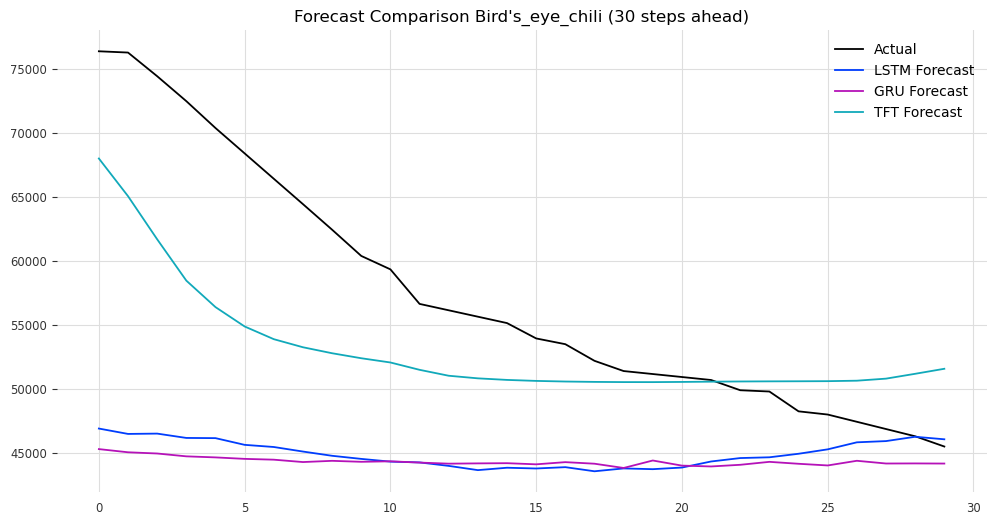

In [41]:
#%%capture model_results.txt

# Print results
print("\nForecasting Performance Comparison:")
for model, metrics in results.items():
    print(f"\n{model}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

# Visualize forecasts
plt.figure(figsize=(12, 6))
plt.plot(test_array[:N_STEPS_OUT], label='Actual')
plt.plot(lstm_forecast, label='LSTM Forecast')
plt.plot(gru_forecast, label='GRU Forecast')
plt.plot(tft_forecast, label='TFT Forecast')
plt.legend()
plt.title(f"Forecast Comparison {commodity} ({N_STEPS_OUT} steps ahead)")
plt.show()

In [74]:
from plyer import notification

def notify_me():
    notification.notify(
        title="Jupyter Notebook",
        message="Your notebook has finished running!",
        app_icon=None,  # Path to an icon file if you want
        timeout=10  # Notification lasts for 10 seconds
    )

# Call this function at the end of the notebook to send the notification
notify_me()


In [58]:
tft_forecast
# Convert array to pandas DataFrame
LSTM_df = pd.DataFrame(lstm_forecast, columns=[commodity])
GRU_df = pd.DataFrame(gru_forecast, columns=[commodity])
TFT_df = pd.DataFrame(tft_forecast, columns=[commodity])

# Save DataFrame to CSV
LSTM_df.to_csv(rf'C:\Users\amali\Downloads\LSTM_{commodity}.csv', index=False)
GRU_df.to_csv(rf'C:\Users\amali\Downloads\GRU_{commodity}.csv', index=False)
#TFT_df.to_csv(rf'C:\Users\amali\Downloads\TFT_{commodity}.csv', index=False)

print("Array has been written to output.csv")

Array has been written to output.csv
